In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle
import matplotlib.pyplot as plt
import time
import datetime
import re
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
movies_to_skip = pickle.load(open("Movies to skip.p", "rb"))
all_frames = pickle.load(open("Scraped_data.p", "rb"))
weeklies, summaries, imdbs = all_frames

In [3]:
weeklies

,index_name,Name,Date,Rank,Weekly,%LW,Theaters,Change,Avg,To Date,Week,Estimated
0,Guardians of the Galaxy,Guardians of the Galaxy,Aug 1-7,1,"$134,390,839",-,"4,080",-,"$32,938","$134,390,839",1,false
1,Guardians of the Galaxy,Guardians of the Galaxy,Aug 8-14,2,"$63,154,982",-53%,"4,088",+8,"$15,448","$197,545,821",2,false
2,Guardians of the Galaxy,Guardians of the Galaxy,Aug 15-21,2,"$36,708,036",-41.9%,"3,697",-391,"$9,929","$234,253,857",3,false
3,Guardians of the Galaxy,Guardians of the Galaxy,Aug 22-28,1,"$24,043,411",-34.5%,"3,371",-326,"$7,132","$258,297,268",4,false
4,Guardians of the Galaxy,Guardians of the Galaxy,Aug 29-Sep 4,1,"$26,110,586",+8.6%,"3,462",+91,"$7,542","$284,407,854",5,false
...,...,...,...,...,...,...,...,...,...,...,...,...
23885,TINY: The Life of Erin Blackwell,Jihadists,Feb 1-7,88,$752,-44.4%,1,-,$752,"$2,104",2,false
23886,I Lost Albert2019 Re-release,A Fish in the Bathtub,Nov 8-14,97,"$1,237",-,3,-,$412,"$1,237",1,false
23887,In Safe Hands,The Hours and Times,Mar 1-3,101,"$1,273",-,1,-,"$1,273","$1,273",1,false
23888,Little Q,Tall Tales from the Magical Garden of Antoon K...,Jan 11-17,91,$172,-,20,-,$8,$172,1,false


In [4]:
df_fixed_lines = weeklies.copy()

#First, processing the weekly values.

#Convert the "Average" column, holding per-threater weekly take, by converting it into an integer value.
df_fixed_lines["Avg"] = df_fixed_lines["Avg"].apply(lambda x: int(x.replace(",", "").replace("$", "").replace("-", "1")))

#Deal with cases where a movie was shown for only one week.
df_fixed_lines["Week"] = df_fixed_lines["Week"].apply(lambda x: int(x.replace("-", "1")))

#Determine 'peak' weekly per-theater value.
for_max_value = df_fixed_lines.rename(columns={"Avg": "Peak"}).groupby(["index_name"])[["index_name", "Peak"]].max().reset_index(drop=True).merge(df_fixed_lines)

#Identify how long a movie was shown since its initial date.
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"In Theaters"}).groupby("index_name")["In Theaters"].max().reset_index())
#Identify how many weeks of data we have- if this is different from "In Theaters", we have gaps. 
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"Weeks of Data"}).groupby("index_name")["Weeks of Data"].count().reset_index())

In [5]:
biggest_movies = for_max_value.sort_values("Avg", ascending=False)["Name"].unique()

In [6]:
def to_week_number(item):
    '''Converts a week of the form 'May 31-Jun 6' to a week number of the year.'''
    item=item.split("-")[0]
    month, day= item.split(" ")
    if len(day)==1:
        day = " "+day
    return datetime.datetime.strptime(month+day, "%b%d").isocalendar()[1]
for_max_value["Week_of_Year"] = for_max_value["Date"].apply(to_week_number)

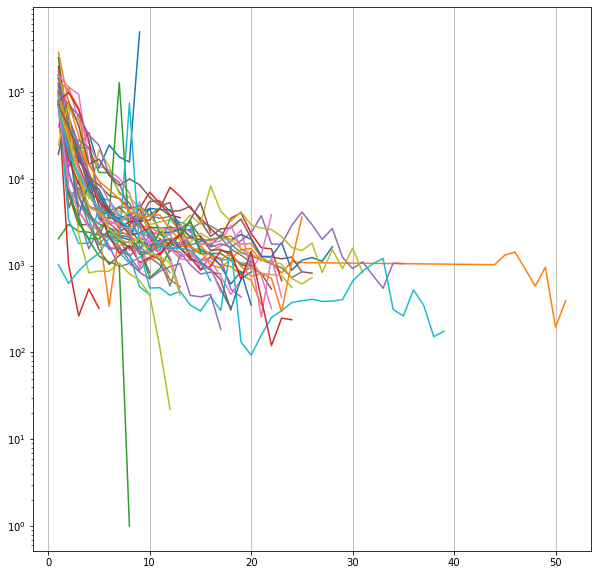

In [7]:
#Plotting for reference: Decay rate as a function of time, as compared to the peak box office per-theater.
plt.figure(figsize=(10, 10))
plt.yscale("log")
for name in biggest_movies[0:50]:
    movieselector = for_max_value[for_max_value["Name"]==name]
    plt.plot(movieselector["Week"], movieselector["Avg"])
plt.grid(axis="x")

In [8]:
#Use the MLB to dummy out the genre.
mlb = MultiLabelBinarizer()
genres = summaries["Genres"]
set_of_genres = set().union(*genres)
vals = mlb.fit_transform(genres)
cols = mlb.classes_
movie_genres = pd.DataFrame(data=vals, columns=cols)
movies_and_genres = summaries.reset_index().merge(movie_genres.reset_index())

set_of_genres = set().union(*genres)

#Because MPAA rating is a single value instead of a list, this is easier.
for rating in set_of_genres:
    movies_and_genres[rating] = movies_and_genres["MPAA"]==rating

In [10]:
processed_data = for_max_value, movies_and_genres, imdbs

pickle.dump(processed_data, open("Processed_data.p", "wb"))